<a href="https://colab.research.google.com/github/ananthikalogu/codsoft/blob/main/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install -q transformers accelerate sentencepiece ftfy datasets
!pip install -q torch torchvision pillow


import io, os, sys, math, requests
from PIL import Image
import torch
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer


MODEL_NAME = "nlpconnect/vit-gpt2-image-captioning"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = VisionEncoderDecoderModel.from_pretrained(MODEL_NAME).to(device)
feature_extractor = ViTImageProcessor.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

gen_kwargs = dict(
    max_length=50,
    num_beams=4,
    early_stopping=True,
    no_repeat_ngram_size=2,
    temperature=1.0,
    top_k=50,
    top_p=0.9
)


def load_image_from_file(path_or_fileobj):
    if isinstance(path_or_fileobj, (str, os.PathLike)):
        return Image.open(path_or_fileobj).convert("RGB")
    elif hasattr(path_or_fileobj, "read"):
        return Image.open(path_or_fileobj).convert("RGB")
    else:
        raise ValueError("Unsupported image input")

def preprocess_images(pil_images):

    pixel_values = feature_extractor(images=pil_images, return_tensors="pt").pixel_values
    return pixel_values.to(device)

def generate_caption_for_pil(pil_img):
    model.eval()
    pixel_values = preprocess_images([pil_img])
    with torch.no_grad():
        output_ids = model.generate(pixel_values, **gen_kwargs)
    captions = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    return captions[0].strip()

def caption_from_url(url):
    resp = requests.get(url, stream=True)
    resp.raise_for_status()
    img = Image.open(io.BytesIO(resp.content)).convert("RGB")
    caption = generate_caption_for_pil(img)
    return caption

sample_url = "https://images.unsplash.com/photo-1546182990-dffeafbe841d"
try:
    demo_caption = caption_from_url(sample_url)
    print("Demo image caption:", demo_caption)
except Exception as e:
    print("Demo failed (maybe network blocked). Upload an image instead or replace sample_url.", e)

def caption_images_in_folder(folder_path, ext=("jpg","jpeg","png")):
    results = {}
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(tuple(ext))]
    for f in files:
        path = os.path.join(folder_path, f)
        img = load_image_from_file(path)
        caption = generate_caption_for_pil(img)
        results[f] = caption
        print(f"{f} -> {caption}")
    return results


def show_image_and_caption(pil_img, caption=None, title=None):
    from IPython.display import display, HTML
    display(pil_img.resize((512, int(512 * pil_img.height / pil_img.width))))
    if caption is None:
        caption = generate_caption_for_pil(pil_img)
    display(HTML(f"<p style='font-size:16px'><b>Caption:</b> {caption}</p>"))




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 374.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.0 MB/s eta 0:00:00
Device: cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


Demo image caption: a large brown bear standing in a grassy area


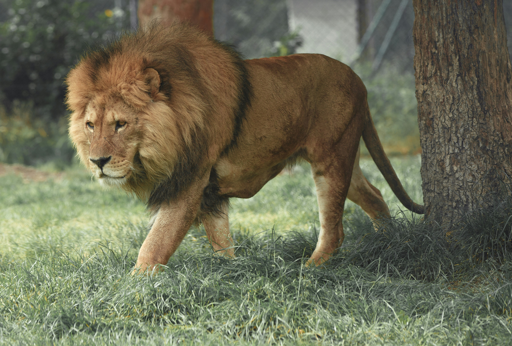

In [2]:
show_image_and_caption(Image.open(io.BytesIO(requests.get(sample_url, stream=True).content)).convert("RGB"), demo_caption)